In [78]:
# !pip install plotly

# import plotly.express as px

In [79]:
import pandas as pd
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [80]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt

In [81]:
# pd.options.plotting.backend = "plotly"

In [82]:
df_train = pd.read_csv('training_data.csv')

In [83]:
df_train.columns

Index(['PatientID', 'Resp', 'PR Seq', 'RT Seq', 'VL-t0', 'CD4-t0'], dtype='object')

In [84]:
df_train

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.30,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.60,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.20,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.70,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.50,572
...,...,...,...,...,...,...
995,996,0,NaN,CCCATTAGTCCTATTGARACTGTACCAGTAMAATTAAAGCCAGGAA...,3.15,354
996,997,0,NaN,CCCATYAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.50,50
997,998,0,NaN,CCCATYAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.10,369
998,999,0,NaN,CCTATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.37,127


In [85]:
feature = 'RT Seq'

#CNN

In [86]:
df_train['Resp'].value_counts()
# strongly weighted towards 0

0    794
1    206
Name: Resp, dtype: int64

In [87]:
# df_train.plot.scatter(x='CD4-t0', y='VL-t0')

In [88]:
df_train[feature].apply(lambda x: len(str(x))).value_counts()

900     150
909      93
903      88
1005     80
750      74
       ... 
1482      1
1479      1
951       1
963       1
1032      1
Name: RT Seq, Length: 116, dtype: int64

In [89]:
# align_dynamic2(s1,s2)

In [90]:
len(df_train[feature][0])

1005

In [91]:
seq = df_train[feature][0]
d = {}
unique = 0
for c in seq:
  if c not in d:
    d[c] = unique
    unique += 1
d

{'A': 1, 'C': 0, 'G': 3, 'K': 8, 'M': 6, 'R': 7, 'T': 2, 'W': 5, 'Y': 4}

In [92]:
df_arr = pd.DataFrame()
arr = []
for k in d:
  s = []
  for c in seq:
    if c == k:
      s.append(1)
    else:
      s.append(0)
  arr.append(s)
  df_arr[k] = s
df_arr

,C,A,T,G,Y,W,M,R,K
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1000,0,1,0,0,0,0,0,0,0
1001,0,1,0,0,0,0,0,0,0
1002,0,0,0,1,0,0,0,0,0
1003,0,0,0,1,0,0,0,0,0


In [93]:
df_arr.sum()

C    167
A    402
T    218
G    210
Y      4
W      1
M      1
R      1
K      1
dtype: int64

In [94]:
# R: G or A
# Y: C or T
def encode(seq,d,length):
    arr = []
    for k in d:
      s = []
      for c in seq:
          if c == k:
              s.append(1)
          else:
              s.append(0)
      res = [0] * (length - len(s))
      s.extend(res)
      arr.append(s)
    return np.array(arr)

In [95]:
df_train.dropna(inplace=True)

In [96]:
# get the longest sequence length
length = max(df_train[feature].apply(lambda x : len(x)))
# one-hot encode each sequence
encoded = []
for seq in df_train[feature]:
  encoded.append(encode(seq,d,length))
np.shape(encoded)

(920, 9, 1482)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(encoded, np.array(df_train['Resp']), test_size=0.20)

In [98]:
np.array(X_train[0])

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [99]:
pd.Series(y_train).value_counts()

0    594
1    142
dtype: int64

In [100]:
# upsampled_x=[]
# upsampled_y=[]
# for i,d in enumerate(X_train):
#     upsampled.append(d)
#     if y_train[i]==1:
        

In [101]:
np.shape(X_train), np.shape(y_train)

((736, 9, 1482), (736,))

In [102]:
np.shape(X_test), np.shape(y_test)

((184, 9, 1482), (184,))

In [103]:
X_train = np.reshape(X_train,(736,9,1482,1))
X_test = np.reshape(X_test,(184,9,1482,1))

In [104]:
input_shape = (np.shape(X_train)[1],np.shape(X_train)[2],1)
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu',padding='same', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=3, padding='same',activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
batch_size = 64
num_epoch = 30
#model training
model_log = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,
          validation_data = (X_test,y_test),
        #   class_weight={0:1, 1:2}
          )

Epoch 1/30
12/12 [==============================] - 4s 314ms/step - loss: 2.2738 - accuracy: 0.6889 - val_loss: 0.6612 - val_accuracy: 0.7554
Epoch 2/30
12/12 [==============================] - 4s 294ms/step - loss: 0.4941 - accuracy: 0.8071 - val_loss: 0.5437 - val_accuracy: 0.7554
Epoch 3/30
12/12 [==============================] - 4s 295ms/step - loss: 0.4478 - accuracy: 0.8166 - val_loss: 0.5792 - val_accuracy: 0.7554
Epoch 4/30
12/12 [==============================] - 4s 294ms/step - loss: 0.4325 - accuracy: 0.8207 - val_loss: 0.5427 - val_accuracy: 0.7554
Epoch 5/30
12/12 [==============================] - 4s 293ms/step - loss: 0.4328 - accuracy: 0.8234 - val_loss: 0.5600 - val_accuracy: 0.7554
Epoch 6/30
12/12 [==============================] - 4s 293ms/step - loss: 0.4218 - accuracy: 0.8234 - val_loss: 0.5444 - val_accuracy: 0.7554
Epoch 7/30
12/12 [==============================] - 4s 294ms/step - loss: 0.4189 - accuracy: 0.8247 - val_loss: 0.5711 - val_accuracy: 0.7554
Epoch 

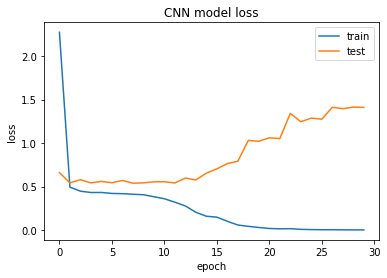

In [105]:
history = model_log.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [106]:
y_pred = model.predict(X_test)
y_pred = list(map(lambda x: int(x>0.5), y_pred))
accuracy_score(y_test,y_pred)

0.7119565217391305

In [107]:
confusion_matrix(y_test, y_pred)

array([[121,  18],
       [ 35,  10]])

#Autoencoder

In [108]:
df_train.head()

,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572


In [109]:
df_train.dropna(subset=[feature],inplace=True)

In [110]:
all_seq = ''
for prseq in df_train[feature]:
    all_seq+=str(prseq)
char_index = list(set(all_seq))

In [111]:
char_to_int = dict((c, i) for i, c in enumerate(char_index))

In [112]:
max_len = df_train[feature].apply(lambda x: len(str(x))).max()

In [113]:
char_to_int

{'A': 10,
 'B': 3,
 'C': 0,
 'D': 12,
 'G': 9,
 'H': 11,
 'K': 2,
 'M': 8,
 'N': 4,
 'R': 7,
 'S': 5,
 'T': 1,
 'V': 14,
 'W': 13,
 'Y': 6}

In [114]:
def encode_sequence_list(seqs,max_len):
    out =''
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    return pad_sequences(encoded_seqs, padding='post')
def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

In [115]:
encoded_seqs = encode_sequence_list(df_train[feature],max_len)

In [116]:
encoded_seqs.shape

(920, 1482)

In [117]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
scaled_seqs = scaler.fit_transform(encoded_seqs)
#Create a test and train sets of our data
X_train, X_test, y_train, y_test = train_test_split(scaled_seqs, np.array(df_train['Resp']), test_size=0.20)

In [118]:
input_dim = X_train.shape[1] # the # features
encoding_dim = 8 # first layer
hidden_dim = int(encoding_dim / 2) #hidden layer

nb_epoch = 250
batch_size = 64
learning_rate = 0.1

In [119]:
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [120]:
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model_seqs2.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [121]:
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/250
12/12 [==============================] - 1s 27ms/step - loss: 0.3327 - accuracy: 0.0000e+00 - val_loss: 0.3148 - val_accuracy: 0.0000e+00
Epoch 2/250
12/12 [==============================] - 0s 13ms/step - loss: 0.2871 - accuracy: 0.0000e+00 - val_loss: 0.2615 - val_accuracy: 0.0000e+00
Epoch 3/250
12/12 [==============================] - 0s 11ms/step - loss: 0.2346 - accuracy: 0.0000e+00 - val_loss: 0.2095 - val_accuracy: 0.0000e+00
Epoch 4/250
12/12 [==============================] - 0s 13ms/step - loss: 0.1849 - accuracy: 0.0000e+00 - val_loss: 0.1628 - val_accuracy: 0.0000e+00
Epoch 5/250
12/12 [==============================] - 0s 13ms/step - loss: 0.1418 - accuracy: 0.0000e+00 - val_loss: 0.1250 - val_accuracy: 0.0000e+00
Epoch 6/250
12/12 [==============================] - 0s 12ms/step - loss: 0.1086 - accuracy: 0.0000e+00 - val_loss: 0.0978 - val_accuracy: 0.0000e+00
Epoch 7/250
12/12 [==============================] - 0s 11ms/step - loss: 0.0858 - accuracy: 0.0000e

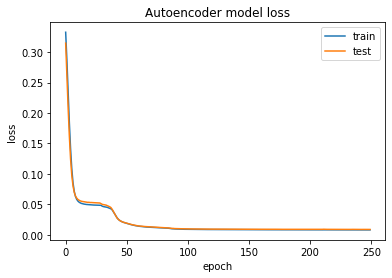

In [122]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Autoencoder model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [123]:
prseq = df_train[[feature,'Resp']]

In [124]:
#encode all the data
encoded_seqs = encode_sequence_list(prseq[feature],297)
#scale it
scaled_data = MinMaxScaler().fit_transform(encoded_seqs)
#predict it
predicted = autoencoder.predict(scaled_data)
#get the error term
mse = np.mean(np.power(scaled_data - predicted, 2), axis=1)
#now add them to our data frame
prseq['MSE'] = mse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [125]:
prseq

,RT Seq,Resp,MSE
0,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,0,0.004934
1,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,0,0.004722
2,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,0,0.003537
3,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,0,0.009538
4,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,0,0.003682
...,...,...,...
915,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,0,0.006178
916,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCAGGAA...,0,0.005483
917,CCCATTAGTCCTATTAAAACTGTACCAGTAAAATTAAAGCCAGGAA...,0,0.011560
918,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAACCGGGAA...,1,0.004824


In [126]:
prseq.groupby('Resp')['MSE'].median()

Resp
0    0.005565
1    0.007337
Name: MSE, dtype: float64

In [127]:
predicted = autoencoder.predict(X_test)
#get the error term
mse = np.mean(np.power(X_test - predicted, 2), axis=1)
#now add them to our data frame
y_pred = mse > 0.004

In [128]:
confusion_matrix(y_test, y_pred)

array([[ 35, 107],
       [  3,  39]])

In [129]:
(95+31)/len(y_test)

0.6847826086956522

# XGBoost

In [130]:
pip install XGBoost

In [131]:
import xgboost as xgb

In [132]:
df_train.dropna(inplace=True)

In [133]:
def splitpad(txt,padlen):
    out=[]
    for c in txt:
        out.append(c)
    out.extend([0]*padlen-len(out))
    return out

In [134]:
pr_seq = pd.DataFrame()
for i in range(length):
    pr_seq[i] = df_train[feature]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(scaled_seqs, np.array(df_train['Resp']), test_size=0.20)

In [136]:
xgb_classifier = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)
xgb_classifier.fit(X_train,y_train)

XGBClassifier(alpha=10, max_depth=5, n_estimators=10)

In [137]:
y_pred = xgb_classifier.predict(X_test)

In [138]:
confusion_matrix(y_test, y_pred)

array([[140,   4],
       [ 29,  11]])

#explore

In [139]:
from pdb import set_trace

In [140]:
!pip install XGBoost
import xgboost as xgb

In [141]:
def splitpad(txt,padlen):
    out = []
    for c in txt:
        out.append(c)
    out.extend([0]*(padlen-len(out)))
    return out

In [142]:
df_train.dropna(subset=[feature],inplace=True)

In [143]:
# get the longest sequence length
length = max(df_train[feature].apply(lambda x : len(x)))

In [144]:
seqs = np.array([splitpad(seq,length) for seq in df_train[feature]])

In [145]:
df = pd.DataFrame()
for i in range(length):
    df[i] = seqs[:,i]
df['resp'] = df_train['Resp']
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,resp
0,C,C,C,A,T,T,A,G,T,C,C,T,A,T,T,G,A,A,A,C,T,G,T,A,C,C,A,G,T,A,A,A,G,C,T,A,A,A,G,C,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,C,C,C,A,T,T,A,G,T,C,C,T,A,T,T,G,A,A,A,C,T,G,T,A,C,C,A,G,T,A,A,A,A,T,T,A,A,A,G,C,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,C,C,C,A,T,T,A,G,T,C,C,T,A,T,T,G,A,A,A,C,T,G,T,A,C,C,A,G,T,A,A,A,A,T,T,A,A,A,G,C,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,C,C,C,A,T,T,A,G,T,C,C,T,A,T,T,G,A,A,A,C,T,G,T,A,C,C,A,G,T,A,A,A,A,T,T,A,A,A,G,C,...,A,T,T,C,A,T,C,T,A,G,C,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,C,C,C,A,T,T,A,G,T,C,C,T,A,T,T,G,A,A,A,C,T,G,T,A,C,C,A,G,T,A,A,A,A,T,T,A,A,A,G,C,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
all_codes = []
for i in range(length):
    all_codes.extend(df[i].unique())
all_codes = pd.Series(all_codes).unique()
all_codes = dict(zip(all_codes,range(len(all_codes))))
df_code=pd.DataFrame()
for i in range(length):
    df_code[i] = df[i].apply(lambda x: all_codes[x])

In [147]:
# get the average value at each index in the sequence
avg_seq = []
for i in range(length):
    avg_seq.append(df[i].mode().item())

In [148]:
df_diff=pd.DataFrame()
for i in range(length):
    df_diff[i] = df[i]!=avg_seq[i]
    # df_diff[i] = (df[i]!=avg_seq[i])/(df[i]!=avg_seq[i]).sum

In [149]:
# X_train, X_test, y_train, y_test = train_test_split(df_code, df['resp'], test_size=0.30)

In [150]:
# df_diff
# X_train, X_test, y_train, y_test = train_test_split(df_diff, df['resp'], test_size=0.30)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(df_train[['VL-t0','CD4-t0']], df_train['Resp'], test_size=0.20)

In [152]:
xgb_classifier = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10,scale_pos_weight=1)
xgb_classifier.fit(X_train,y_train)
preds = xgb_classifier.predict(X_test)

In [153]:
confusion_matrix(y_test, preds)

array([[136,   7],
       [ 30,  11]])

In [154]:
feature = 'PR Seq'